In [1]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

## Load

In [2]:
data = load('250404-plastic6')
# data = load('250328-sand1')
noise = data.pop(-1)

## Do fits

[I, omega, alpha] =  [5.91820810e-05 1.51727343e+02 8.90629222e-03]


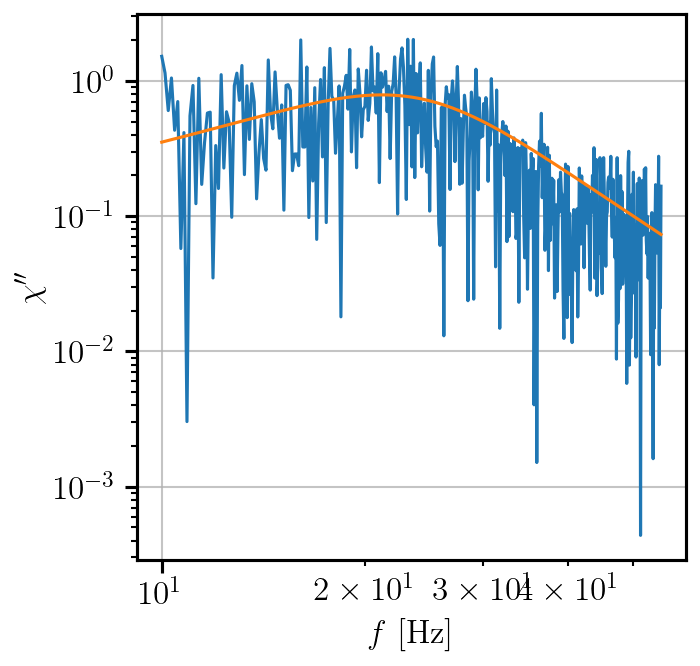

[I, omega, alpha] =  [6.19351985e-05 1.51727343e+02 9.81612946e-03]


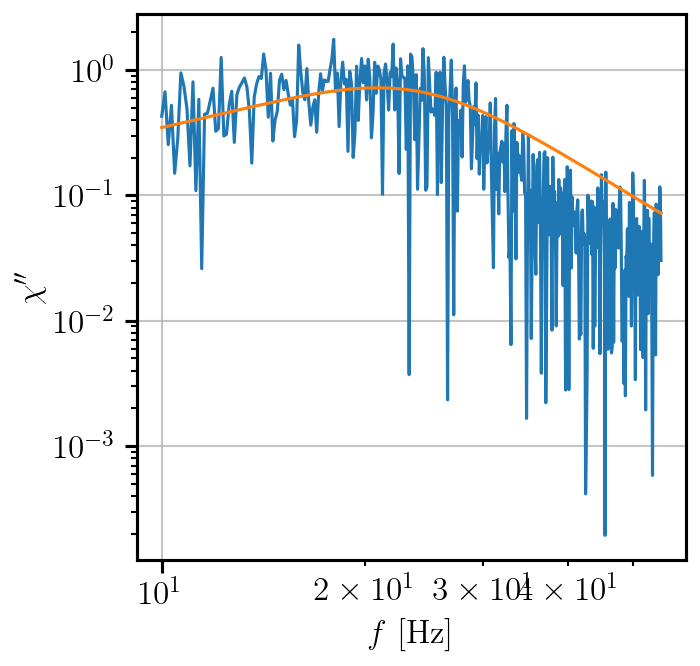

[I, omega, alpha] =  [9.03077385e-05 1.51727343e+02 9.68226591e-03]


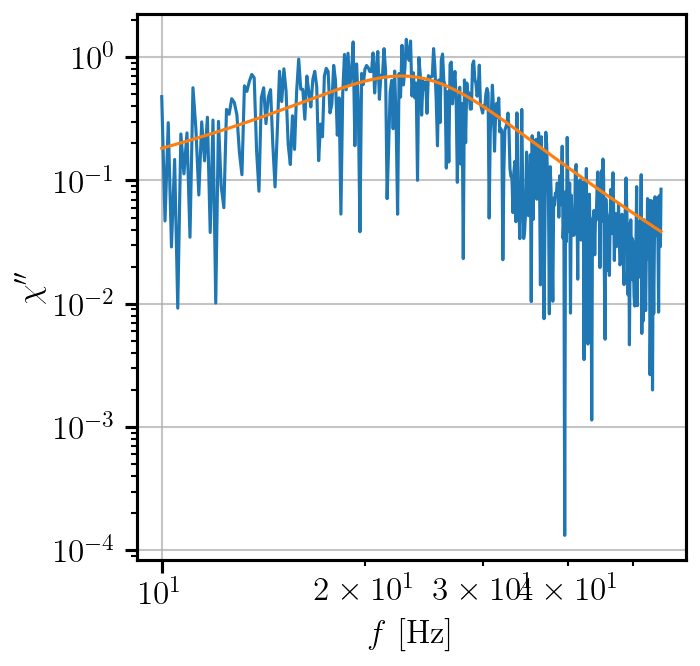

[I, omega, alpha] =  [6.96546346e-05 1.51727343e+02 9.72377978e-03]


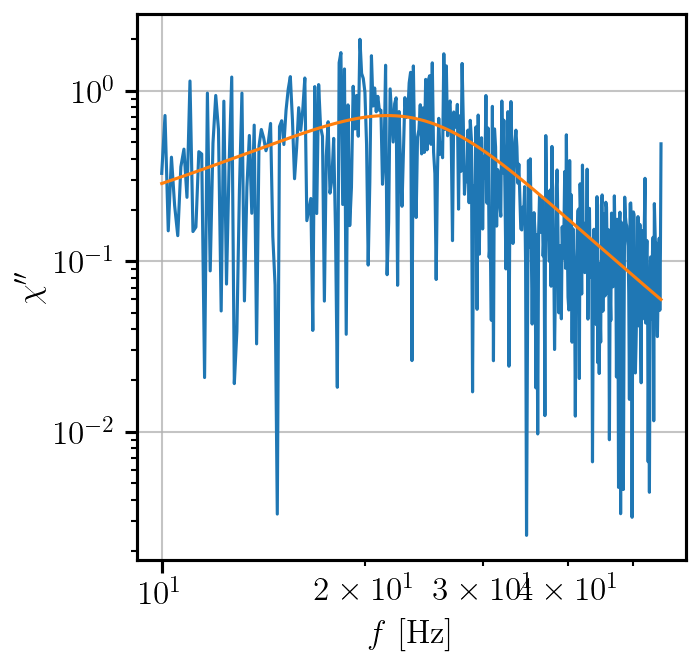

[I, omega, alpha] =  [9.06308925e-05 1.54188723e+02 1.35317151e-02]


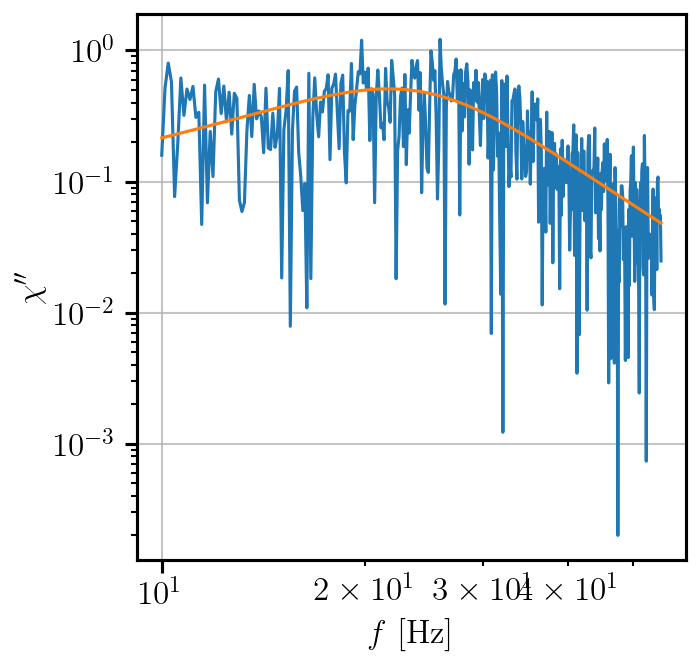

[I, omega, alpha] =  [9.39980809e-05 1.54188723e+02 1.51101422e-02]


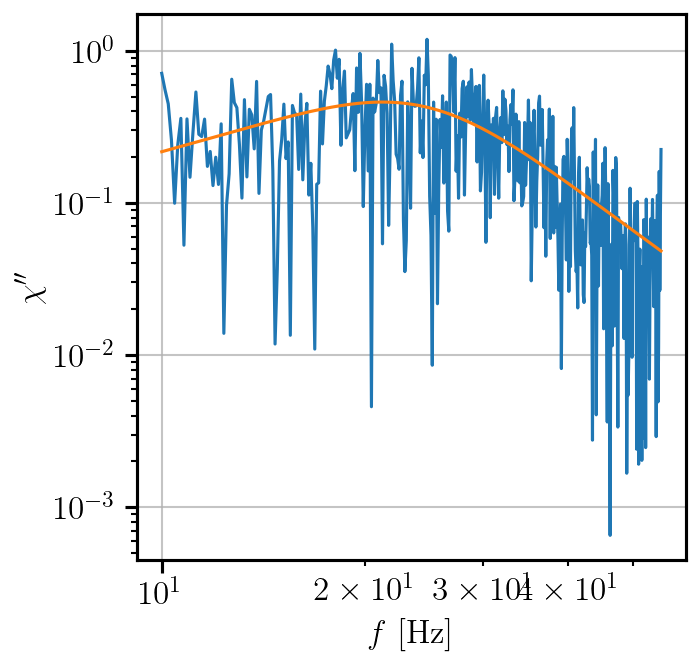

[I, omega, alpha] =  [1.14708097e-04 1.54188723e+02 1.91232269e-02]


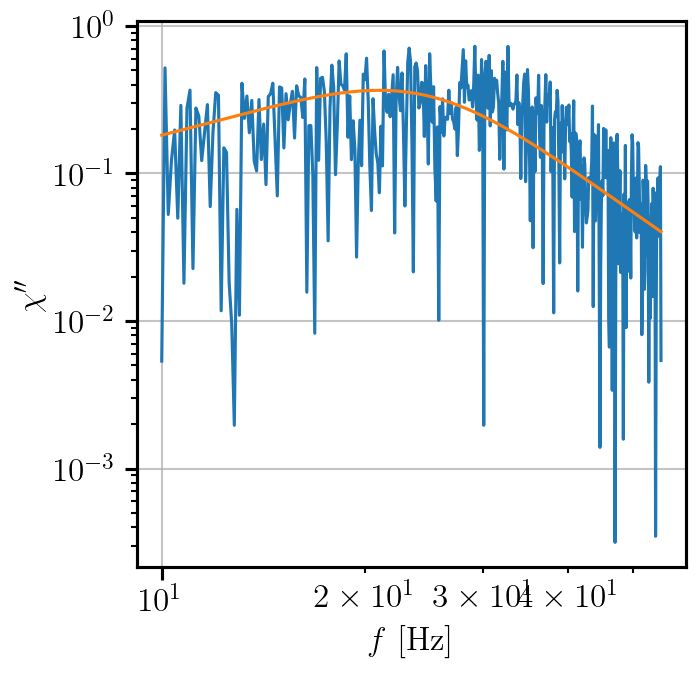

[I, omega, alpha] =  [8.20506878e-05 1.54188723e+02 1.49343921e-02]


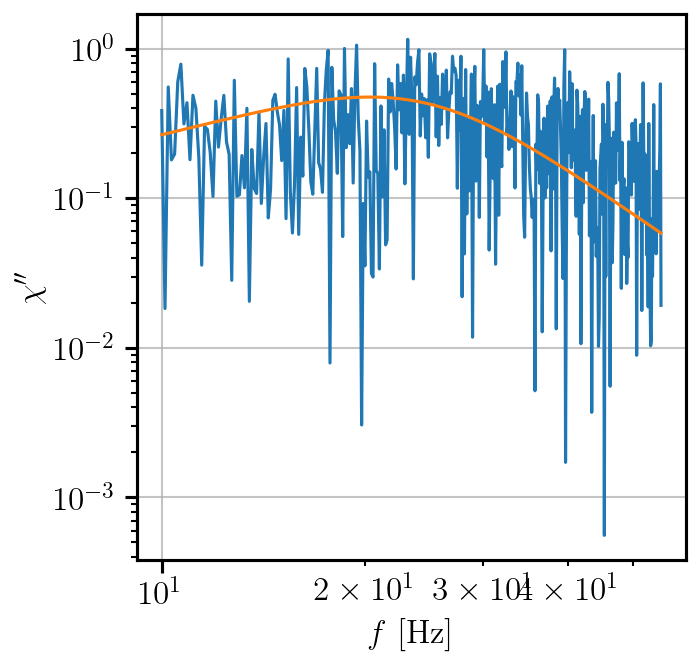

[I, omega, alpha] =  [1.27202930e-04 1.54188723e+02 2.69480417e-02]


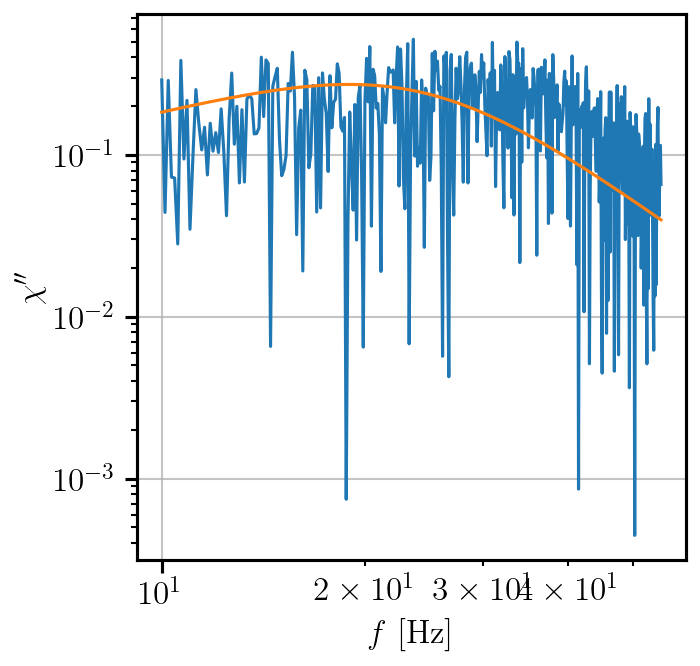

In [3]:
show_plots = True

all_popt_err_pass1 = unp.uarray(np.zeros((len(data), 3)), 0)
for i, step in enumerate(data):
    popt, pcov = sc.optimize.curve_fit(
        imag_chi, step.freqs, step.chi_im,
        bounds=(0, np.inf),
        p0=(1e-4, 56, 0.01)
    )
    all_popt_err_pass1[i] = unp.uarray(popt, np.sqrt(np.diag(pcov)))

    # if show_plots:
    #     print("[I, omega, alpha] = ", popt)
    #     plt.plot(step.freqs, step.chi_im)
    #     plt.loglog(step.freqs, imag_chi(step.freqs, *popt))
    #     plt.xlabel("$f$ [Hz]")
    #     plt.ylabel("$\\chi''$")
    #     plt.show()

I, w0, _ = np.mean(all_popt_err_pass1, axis=0)
dI, dw0, _ = std_devs(np.mean(all_popt_err_pass1, axis=0))
all_popt_err_pass2 = np.zeros_like(all_popt_err_pass1)

for i, step in enumerate(data):
    popt, pcov = sc.optimize.curve_fit(
        imag_chi, step.freqs, step.chi_im,
        bounds=(
            (I.n - dI, w0.n - dw0, 0),
            (I.n + dI, w0.n + dw0, np.inf)
        ),
        p0=(I.n, w0.n, 0.01)
    )
    all_popt_err_pass2[i] = unp.uarray(popt, np.sqrt(np.diag(pcov)))

    if show_plots:
        print("[I, omega, alpha] = ", popt)
        plt.plot(step.freqs, step.chi_im)
        plt.loglog(step.freqs, imag_chi(step.freqs, *popt))
        plt.xlabel("$f$ [Hz]")
        plt.ylabel("$\\chi''$")
        plt.show()

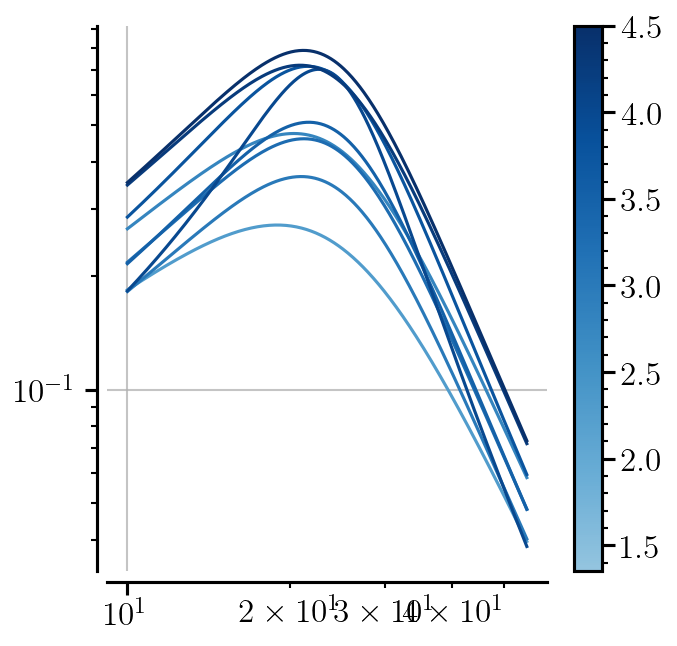

In [4]:
max_amplitude = max(step.imposed_vibration for step in data)
min_amplitude = min(step.imposed_vibration for step in data)

cmap = truncate_colormap(plt.cm.Blues, 0.4, 1.0)
norm = mpl.colors.Normalize(vmin=min_amplitude, vmax=max_amplitude)

fig, ax = plt.subplots()

for i, (popt, step) in enumerate(zip(reversed(nom_vals(all_popt_err_pass2)), reversed(data))):
    color = cmap(step.imposed_vibration / max_amplitude)
    fitted = imag_chi(step.freqs, *popt)
    # ax.loglog(step.freqs, step.chi_abs, c=color)
    ax.loglog(step.freqs, fitted, c=color)

# plt.colorbar()
fig.colorbar(plt.cm.ScalarMappable(norm, cmap), ax=ax)

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_position(('outward', 5))
ax.grid(True, axis='y')
# ax.set_xlim(1e1, 4e1)
# ax.set_ylim(5e-2, 1e1)

## Average $I$, $\omega_0$ and $\alpha$

In [5]:
I, omega0, alpha = np.mean(all_popt_err_pass1, axis=0)
print(f"{I = :.5f} g m²")
print(f"{omega0 = :.5f} Hz")
print(f"{alpha = :.5f} g m² s⁻¹")
I, omega0, alpha = np.mean(all_popt_err_pass2, axis=0)
print(f"{I = :.5f} g m²")
print(f"{omega0 = :.5f} Hz")
print(f"{alpha = :.5f} g m² s⁻¹")

I = 0.00007+/-0.02763 g m²
omega0 = 152.95803+/-1.23069 Hz
alpha = 0.01516+/-0.00028 g m² s⁻¹
I = 0.00009+/-0.00000 g m²
omega0 = 153.09478+/-1.28353 Hz
alpha = 0.01420+/-0.00025 g m² s⁻¹


-0.92+/-0.12


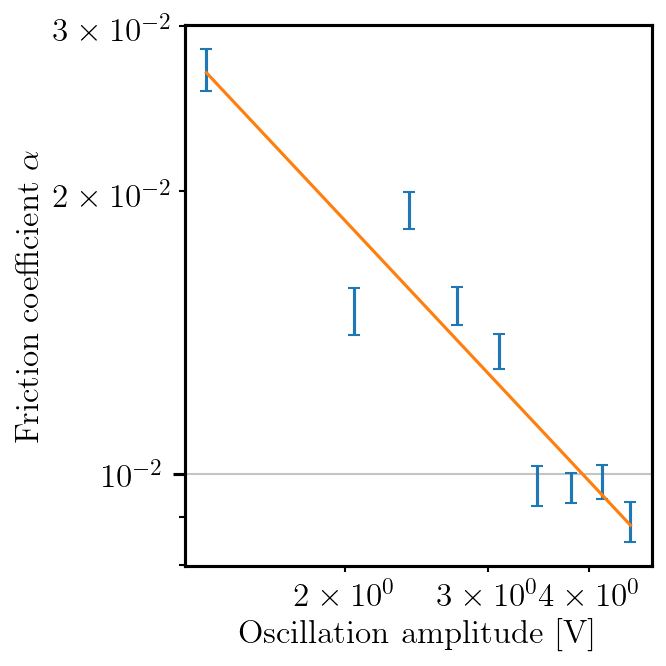

In [7]:
slope, offset = do_fit_alpha(data, all_popt_err_pass2[:, 2], np.arange(9), "../data/plastic_alpha_im")

# plt.text(0.4, 8e-3, fr"$\alpha \sim {slope:.1upL} \Gamma^{{-1}}$")
print(slope)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Oscillation amplitude [V]')
plt.ylabel(r'Friction coefficient $\alpha$')

plt.tight_layout()
plt.savefig('../figures/plastic_alpha_from_chi_im.png')
plt.show()